In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *

2024-07-04 18:18:03.069840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 18:18:03.070013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 18:18:03.205058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

In [8]:
data_directory = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folders = os.listdir(data_directory)

for folder in folders:
    folder_path = os.path.join(data_directory, folder)
    file_list = os.listdir(folder_path)

    for f in file_list:
        file_path = os.path.join(folder_path, f)
        filelist = os.listdir(file_path)

        for file in filelist:
            fpath = os.path.join(file_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')


fpaths = pd.Series(filepaths, name= 'filepaths')
cancer_labels = pd.Series(labels, name='labels')
cancer_df = pd.concat([fpaths, cancer_labels], axis= 1)
cancer_df.labels.value_counts()

labels
Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Name: count, dtype: int64

In [9]:
random_directory = '/kaggle/input/unsplash-random-images-collection/unsplash-images-collection'
random_filepaths = []
random_labels = []


file_list = os.listdir(random_directory)


for file in file_list:
    fpath = os.path.join(random_directory, file)
    random_filepaths.append(fpath)
    random_labels.append('Irrelevant Image')

rand_fpaths = pd.Series(random_filepaths, name= 'filepaths')
irrelevant_labels = pd.Series(random_labels, name='labels')
irrelevant_df = pd.concat([rand_fpaths, irrelevant_labels], axis= 1)
irrelevant_df.labels.value_counts()


labels
Irrelevant Image    802
Name: count, dtype: int64

In [10]:
df = pd.concat([cancer_df,irrelevant_df])
df.labels.value_counts()

labels
Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Irrelevant Image                 802
Name: count, dtype: int64

In [11]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state=42, stratify= strat)


strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state=42, stratify= strat)

In [12]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
BUFFER_SIZE = 1000
DATASET_DIR = data_directory

In [13]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20641 validated image filenames belonging to 6 classes.
Found 2580 validated image filenames belonging to 6 classes.
Found 2581 validated image filenames belonging to 6 classes.


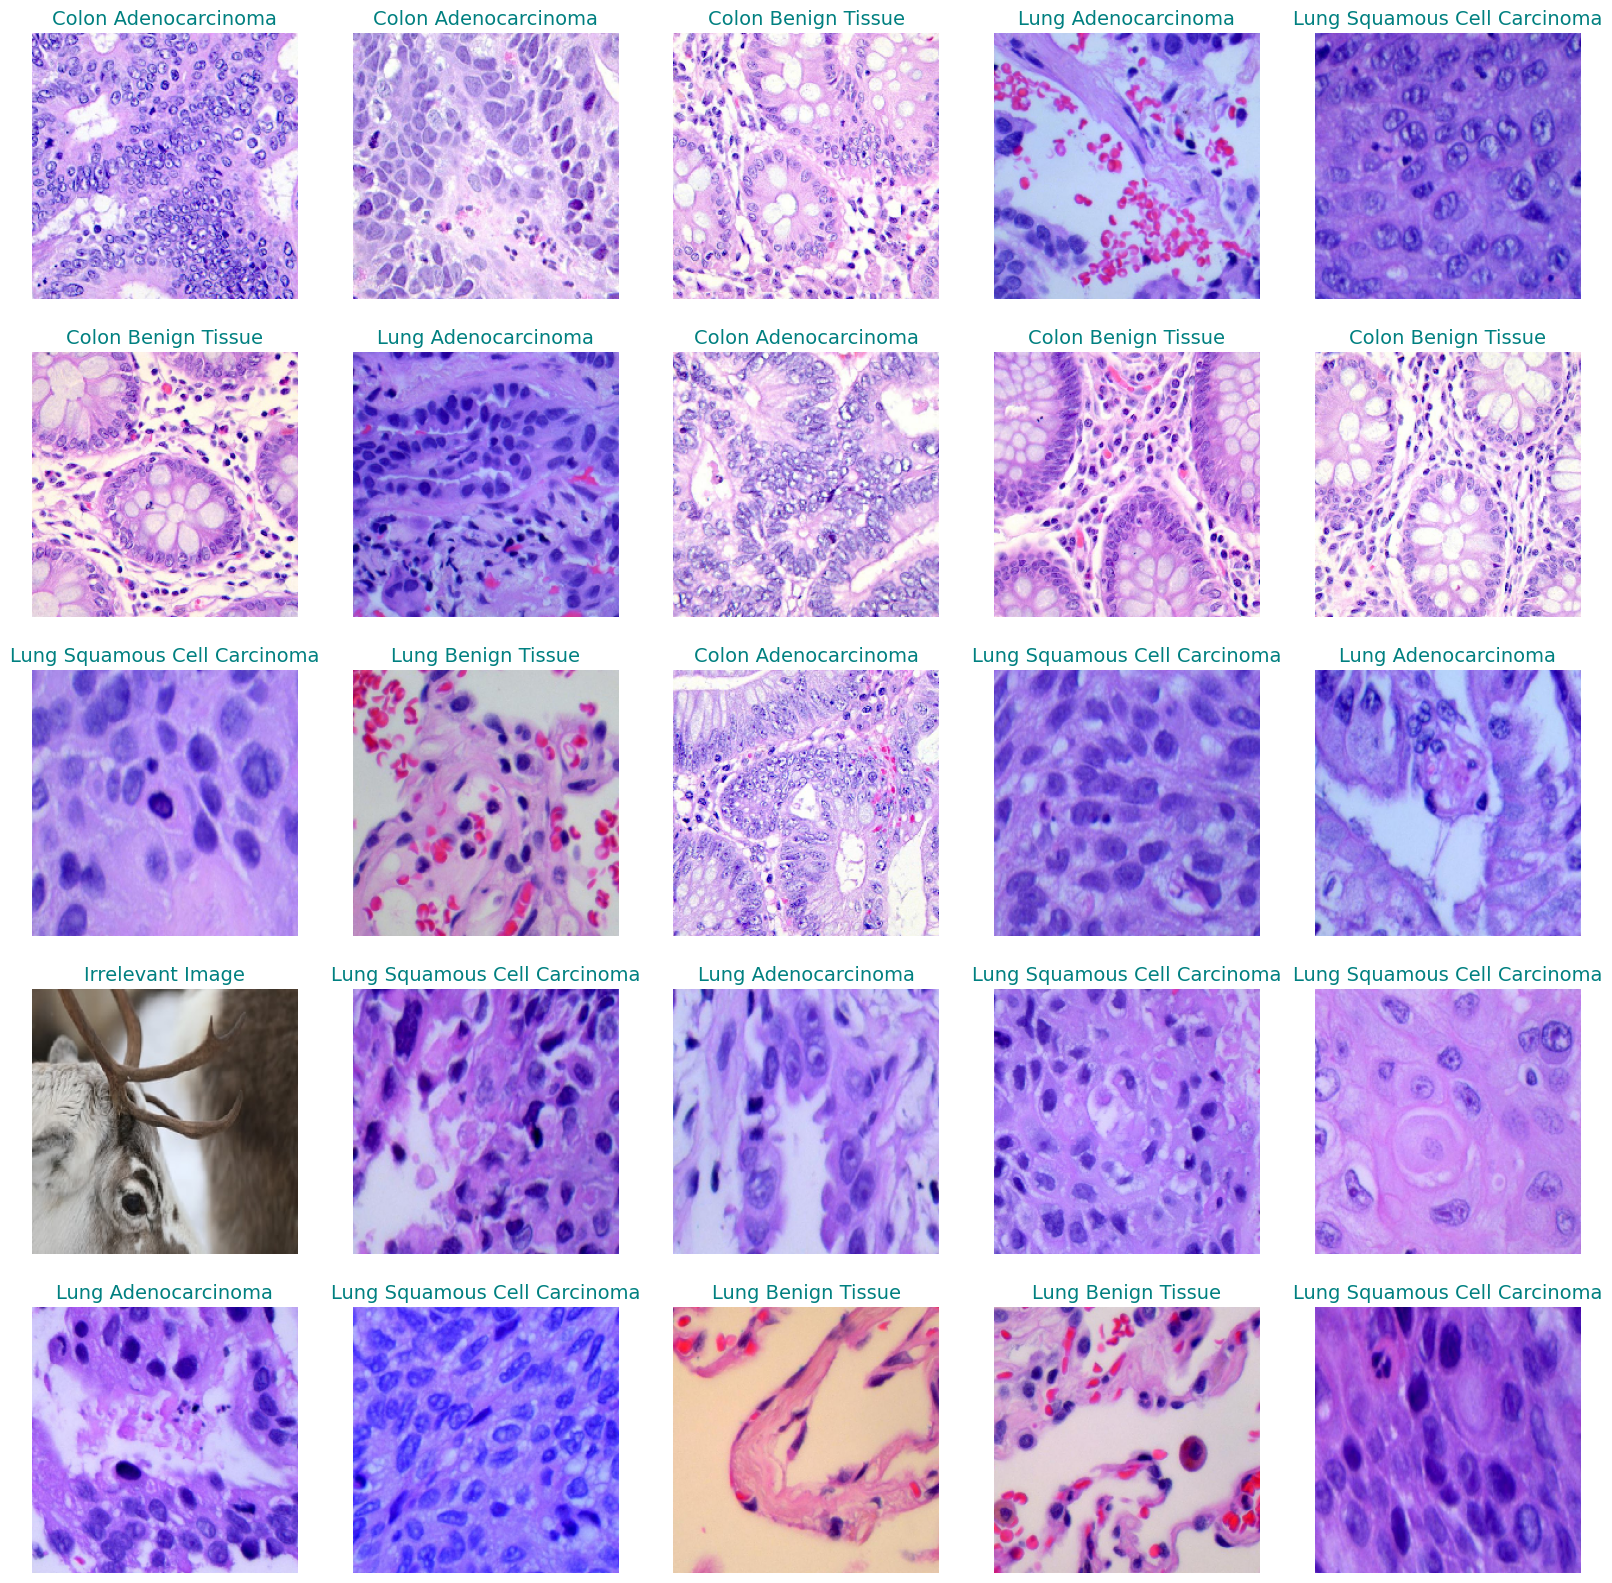

In [14]:
def image_grid(gen , train_df ):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i]/255)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='teal', fontsize=14)
        plt.axis('off')
    plt.show()



image_grid(train_gen, train_df)

In [15]:
class_count = len(list(train_gen.class_indices.keys()))


base_model=tf.keras.applications.resnet.ResNet50(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling="avg") 
x=base_model.output
x=keras.layers.BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x=Dropout(rate=.45)(x) 
x=keras.layers.BatchNormalization()(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',Precision(name = 'precision'), Recall(name = 'recall'),
                                                                                        AUC(num_thresholds=200,
                                                                                           curve='ROC',
                                                                                           summation_method='interpolation',
                                                                                           name='auc'),
                                                                                        MeanAbsoluteError(name='mean_absolute_error', dtype=None),
                                                                                        MeanSquaredError(name='mean_squared_error', dtype=None),
                                                                                        RootMeanSquaredError(name='root_mean_squared_error', dtype=None)])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,727,686 (90.51 MB)

 Trainable params: 23,670,342 (90.30 MB)

 Non-trainable params: 57,344 (224.00 KB)

In [16]:
history = model.fit(x= train_gen, epochs= 15, validation_data= valid_gen,validation_steps= None, shuffle= False)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720118339.450449     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720118339.551790     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9365 - auc: 0.9879 - loss: 0.2399 - mean_absolute_error: 0.0428 - mean_squared_error: 0.0172 - precision: 0.9559 - recall: 0.9142 - root_mean_squared_error: 0.1243

W0000 00:00:1720118581.296002     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720118587.838053     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


323/323 ━━━━━━━━━━━━━━━━━━━━ 356s 856ms/step - accuracy: 0.9366 - auc: 0.9879 - loss: 0.2396 - mean_absolute_error: 0.0428 - mean_squared_error: 0.0172 - precision: 0.9560 - recall: 0.9144 - root_mean_squared_error: 0.1242 - val_accuracy: 0.9659 - val_auc: 0.9987 - val_loss: 0.0913 - val_mean_absolute_error: 0.0163 - val_mean_squared_error: 0.0082 - val_precision: 0.9674 - val_recall: 0.9647 - val_root_mean_squared_error: 0.0908
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 111s 343ms/step - accuracy: 0.9900 - auc: 0.9996 - loss: 0.0463 - mean_absolute_error: 0.0111 - mean_squared_error: 0.0028 - precision: 0.9911 - recall: 0.9886 - root_mean_squared_error: 0.0531 - val_accuracy: 0.9911 - val_auc: 0.9985 - val_loss: 0.0395 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 0.0026 - val_precision: 0.9911 - val_recall: 0.9907 - val_root_mean_squared_error: 0.0506
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 112s 347ms/step - accuracy: 0.9942 - auc: 0.9998 - loss: 0.0302 - mean_absolute_err

In [17]:
print(f"Training loss: {history.history['loss'][-1]:0.2f}\n")
print(f"Training accuracy: {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"Training precision: {history.history['precision'][-1]:0.2f}\n")
print(f"Training recall: {history.history['recall'][-1]:0.2f}\n")

Training loss: 0.00

Training accuracy: 99.89%

Training precision: 1.00

Training recall: 1.00



In [18]:
print(f"Validation loss: {history.history['val_loss'][-1]:0.2f}\n")
print(f"Validation accuracy: {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"Validation precision: {history.history['val_precision'][-1]:0.2f}\n")
print(f"Validation recall: {history.history['val_recall'][-1]:0.2f}\n")

Validation loss: 0.03

Validation accuracy: 98.95%

Validation precision: 0.99

Validation recall: 0.99



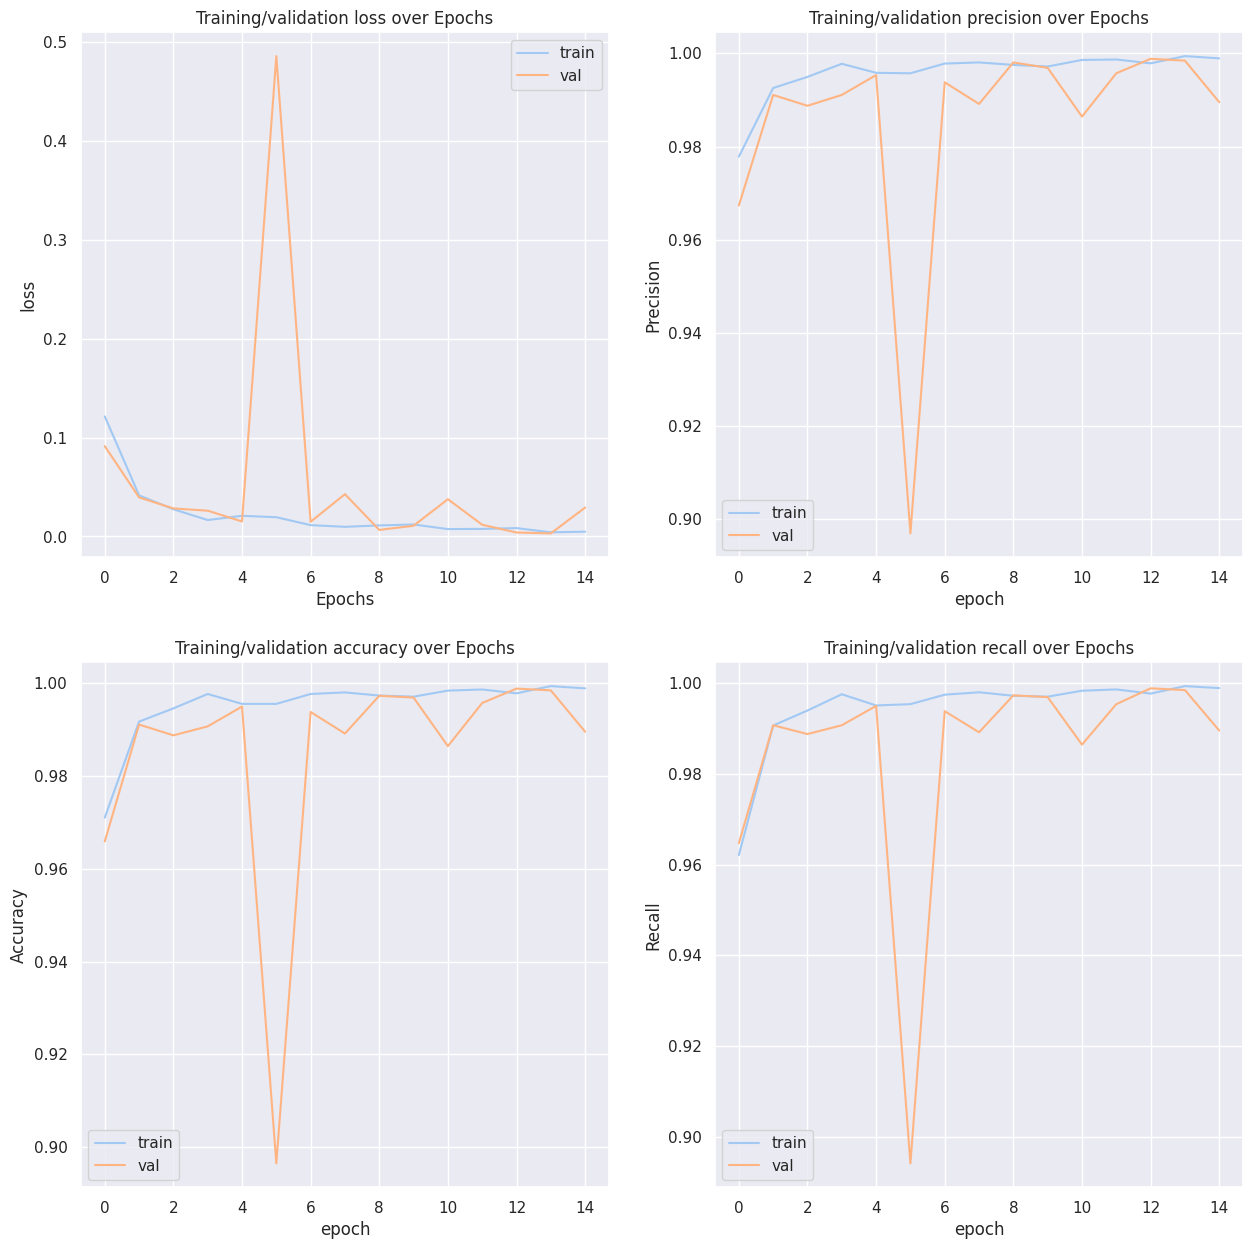

In [20]:
figure , axis = plt.subplots(2,2,figsize=(15,15))


axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='val')
axis[0,0].set_title('Training/validation loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()


axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='val')
axis[1,0].set_title('Training/validation accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()


axis[0,1].plot(history.history['precision'], label='train')
axis[0,1].plot(history.history['val_precision'], label='val')
axis[0,1].set_title('Training/validation precision over Epochs')
axis[0,1].set_xlabel('epoch')
axis[0,1].set_ylabel('Precision')
axis[0,1].legend()


axis[1,1].plot(history.history['recall'], label='train')
axis[1,1].plot(history.history['val_recall'], label='val')
axis[1,1].set_title('Training/validation recall over Epochs')
axis[1,1].set_xlabel('epoch')
axis[1,1].set_ylabel('Recall')
axis[1,1].legend()


In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.9903 - auc: 0.9996 - loss: 0.0279 - mean_absolute_error: 0.0037 - mean_squared_error: 0.0025 - precision: 0.9903 - recall: 0.9903 - root_mean_squared_error: 0.0503
Test Loss:  0.028617223724722862
Test Accuracy:  0.9903138279914856


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 2/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

W0000 00:00:1720120269.875425     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step


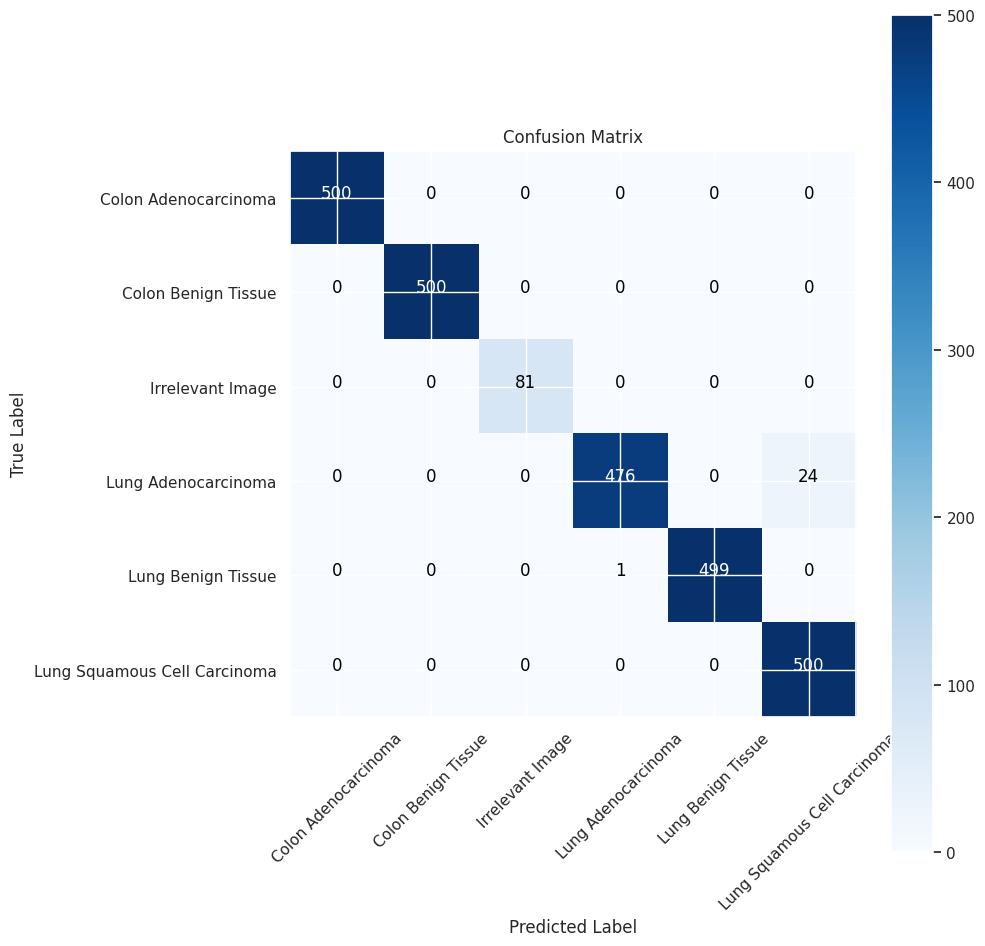

In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [23]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       500
            Irrelevant Image       1.00      1.00      1.00        81
         Lung Adenocarcinoma       1.00      0.95      0.97       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.95      1.00      0.98       500

                    accuracy                           0.99      2581
                   macro avg       0.99      0.99      0.99      2581
                weighted avg       0.99      0.99      0.99      2581



In [24]:
model.save('CNN_Model.h5')

In [28]:
print(classes)

['Colon Adenocarcinoma', 'Colon Benign Tissue', 'Irrelevant Image', 'Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']
